In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

data_dir = Path.cwd() / "dataset"

# check if dataset exists
print("CWD:", Path.cwd())
print("data_dir:", data_dir)
print("exists:", data_dir.exists())
print("files:", [p.name for p in data_dir.glob("*")])

cols = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

train = pd.read_csv(
    data_dir / "adult.data",
    header=None,
    names=cols,
    sep=",",
    skipinitialspace=True,
    na_values="?",
)

test = pd.read_csv(
    data_dir / "adult.test",
    header=None,
    names=cols,
    sep=",",
    skipinitialspace=True,
    na_values="?",
    skiprows=1,
)

test["income"] = test["income"].str.replace(".", "", regex=False)

# strip whitespace
for df in (train, test):
    obj_cols = df.select_dtypes(include="object").columns
    df[obj_cols] = df[obj_cols].apply(lambda s: s.str.strip())

print(train.shape, test.shape)
train.head()

CWD: c:\Users\deniz\Desktop\ML\Capstone1
data_dir: c:\Users\deniz\Desktop\ML\Capstone1\dataset
exists: True
files: ['adult.data', 'adult.names', 'adult.test', 'Index', 'old.adult.names']
(32561, 15) (16281, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
TARGET_COL = "income"
POS_LABEL = ">50K"


def make_y(df):
    return (df[TARGET_COL] == POS_LABEL).astype(int)


y_train = make_y(train)

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
categorical_cols.remove(TARGET_COL)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

Train shape: (32561, 15)
Test shape: (16281, 15)
Numeric cols: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical cols: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


,missing,missing_%
occupation,1843,5.66
workclass,1836,5.64
native-country,583,1.79


,missing,missing_%
occupation,966,5.93
workclass,963,5.91
native-country,274,1.68


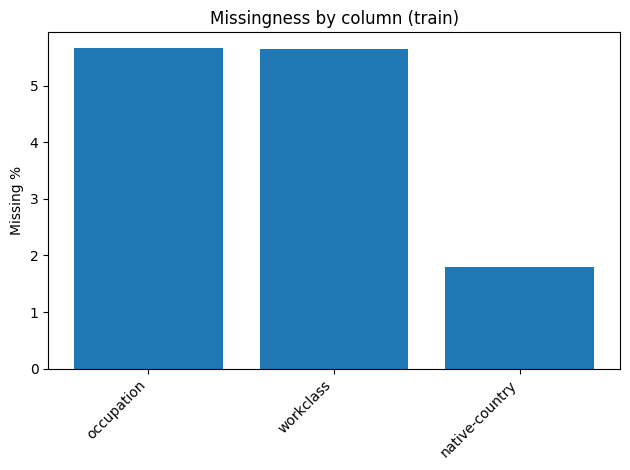

In [3]:
def missing_report(df):
    miss = df.isna().sum()
    pct = (miss / len(df) * 100).round(2)
    out = pd.DataFrame({"missing": miss, "missing_%": pct})
    return out[out["missing"] > 0].sort_values("missing", ascending=False)


miss_train = missing_report(train)
miss_test = missing_report(test)

display(miss_train)
display(miss_test)

# Plot missing % in train
if len(miss_train) > 0:
    plt.figure()
    plt.bar(miss_train.index, miss_train["missing_%"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Missing %")
    plt.title("Missingness by column (train)")
    plt.tight_layout()
    plt.show()

,count,pct_%
income,,
<=50K,24720,75.92
>50K,7841,24.08


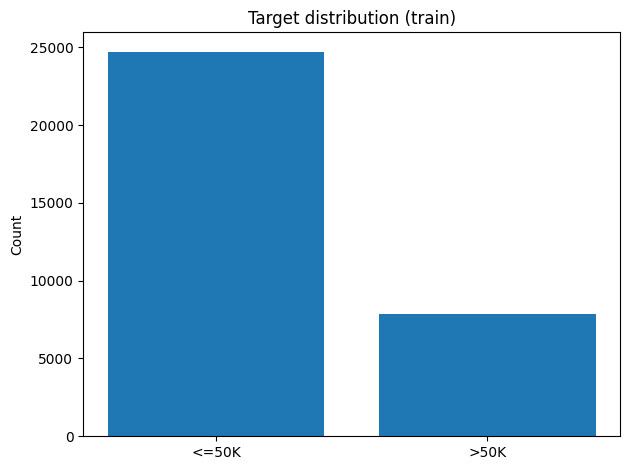

In [4]:
target_counts = train[TARGET_COL].value_counts(dropna=False)
target_pct = (target_counts / len(train) * 100).round(2)

display(pd.DataFrame({"count": target_counts, "pct_%": target_pct}))

plt.figure()
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target distribution (train)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


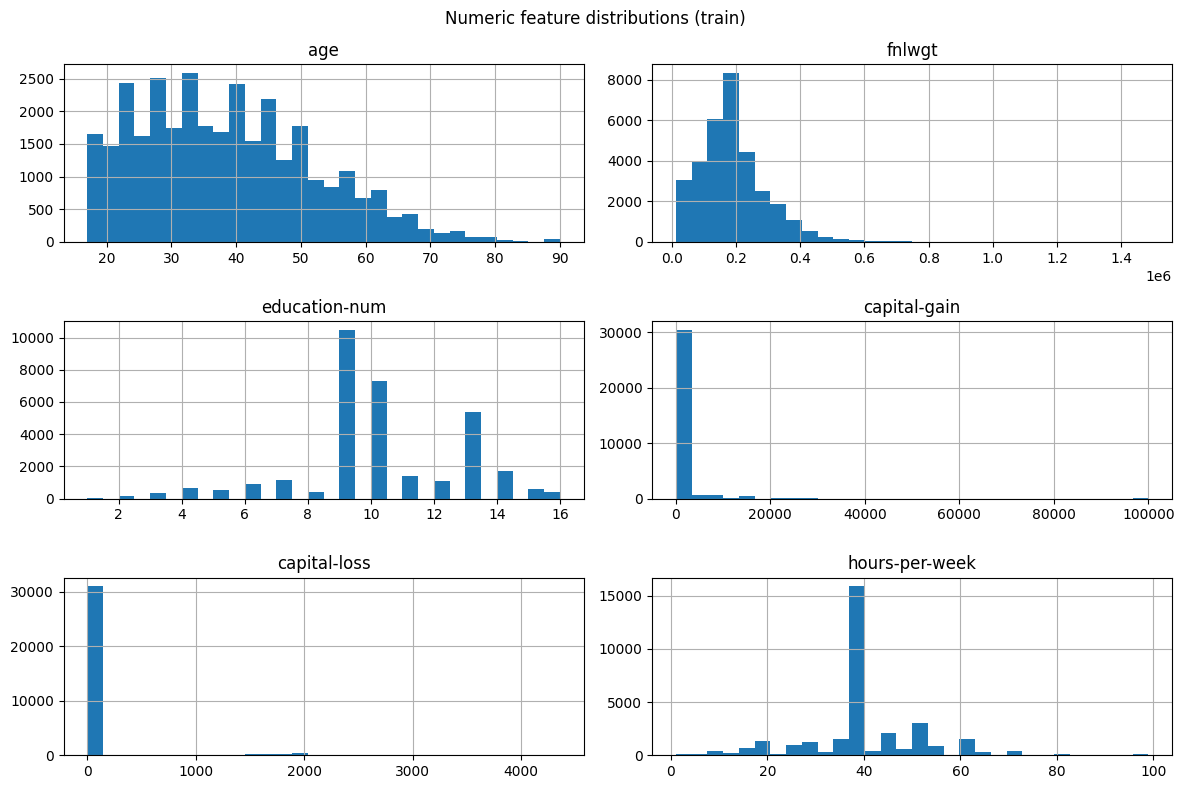

,col,outliers_IQR_count,outliers_IQR_%,q01,q99
5,hours-per-week,9008,27.66,8.0,80.0
3,capital-gain,2712,8.33,0.0,15024.0
4,capital-loss,1519,4.67,0.0,1980.0
2,education-num,1198,3.68,3.0,16.0
1,fnlwgt,992,3.05,27185.8,510072.0
0,age,143,0.44,17.0,74.0


In [5]:
# Basic stats
display(train[numeric_cols].describe().T)

# Histograms
train[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Numeric feature distributions (train)")
plt.tight_layout()
plt.show()


# IQR outlier counts + extreme quantiles
def outlier_report(df, cols):
    rows = []
    for c in cols:
        s = df[c].dropna()
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        out_cnt = ((s < lo) | (s > hi)).sum()
        rows.append(
            {
                "col": c,
                "outliers_IQR_count": int(out_cnt),
                "outliers_IQR_%": round(out_cnt / len(s) * 100, 2),
                "q01": float(s.quantile(0.01)),
                "q99": float(s.quantile(0.99)),
            }
        )
    return pd.DataFrame(rows).sort_values("outliers_IQR_count", ascending=False)


display(outlier_report(train, numeric_cols))

In [6]:
def top_categories(df, col, top_n=10):
    vc = df[col].value_counts(dropna=False)
    return pd.DataFrame({"value": vc.index.astype(str), "count": vc.values}).head(top_n)


for c in categorical_cols:
    print("\n", c)
    display(top_categories(train, c, top_n=10))


 workclass


,value,count
0,Private,22696
1,Self-emp-not-inc,2541
2,Local-gov,2093
3,nan,1836
4,State-gov,1298
5,Self-emp-inc,1116
6,Federal-gov,960
7,Without-pay,14
8,Never-worked,7



 education


,value,count
0,HS-grad,10501
1,Some-college,7291
2,Bachelors,5355
3,Masters,1723
4,Assoc-voc,1382
5,11th,1175
6,Assoc-acdm,1067
7,10th,933
8,7th-8th,646
9,Prof-school,576



 marital-status


,value,count
0,Married-civ-spouse,14976
1,Never-married,10683
2,Divorced,4443
3,Separated,1025
4,Widowed,993
5,Married-spouse-absent,418
6,Married-AF-spouse,23



 occupation


,value,count
0,Prof-specialty,4140
1,Craft-repair,4099
2,Exec-managerial,4066
3,Adm-clerical,3770
4,Sales,3650
5,Other-service,3295
6,Machine-op-inspct,2002
7,nan,1843
8,Transport-moving,1597
9,Handlers-cleaners,1370



 relationship


,value,count
0,Husband,13193
1,Not-in-family,8305
2,Own-child,5068
3,Unmarried,3446
4,Wife,1568
5,Other-relative,981



 race


,value,count
0,White,27816
1,Black,3124
2,Asian-Pac-Islander,1039
3,Amer-Indian-Eskimo,311
4,Other,271



 sex


,value,count
0,Male,21790
1,Female,10771



 native-country


,value,count
0,United-States,29170
1,Mexico,643
2,nan,583
3,Philippines,198
4,Germany,137
5,Canada,121
6,Puerto-Rico,114
7,El-Salvador,106
8,India,100
9,Cuba,95


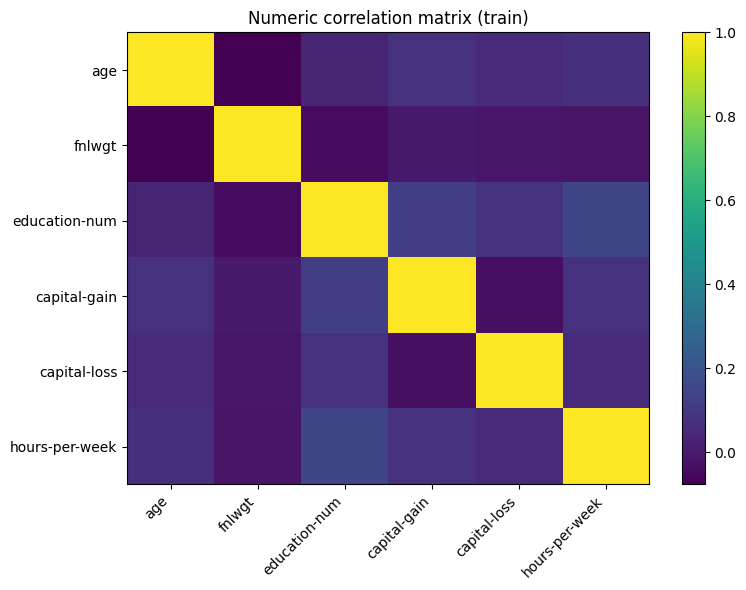

In [7]:
corr = train[numeric_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Numeric correlation matrix (train)")
plt.tight_layout()
plt.show()

In [8]:
num_target_corr = (
    train[numeric_cols]
    .corrwith(y_train)
    .sort_values(key=lambda s: s.abs(), ascending=False)
)
display(num_target_corr.to_frame("corr_with_income(>50K)"))

,corr_with_income(>50K)
education-num,0.335154
age,0.234037
hours-per-week,0.229689
capital-gain,0.223329
capital-loss,0.150526
fnlwgt,-0.009463


In [9]:
def cat_target_table(df, col, y, min_count=100):
    tmp = df[[col]].copy()
    tmp["y"] = y.values
    g = (
        tmp.groupby(col)["y"]
        .agg(["count", "mean"])
        .sort_values("count", ascending=False)
    )
    g = g[g["count"] >= min_count]
    g.rename(columns={"mean": "p(>50K)"}, inplace=True)
    return g.sort_values("p(>50K)", ascending=False)


for c in categorical_cols:
    print("\n", c)
    display(cat_target_table(train, c, y_train, min_count=200).head(15))


 workclass


,count,p(>50K)
workclass,,
Self-emp-inc,1116,0.557348
Federal-gov,960,0.386458
Local-gov,2093,0.294792
Self-emp-not-inc,2541,0.284927
State-gov,1298,0.271957
Private,22696,0.218673



 education


,count,p(>50K)
education,,
Doctorate,413,0.740920
Prof-school,576,0.734375
Masters,1723,0.556587
Bachelors,5355,0.414753
Assoc-voc,1382,0.261216
Assoc-acdm,1067,0.248360
Some-college,7291,0.190235
HS-grad,10501,0.159509
12th,433,0.076212



 marital-status


,count,p(>50K)
marital-status,,
Married-civ-spouse,14976,0.446848
Divorced,4443,0.104209
Widowed,993,0.085599
Married-spouse-absent,418,0.081340
Separated,1025,0.064390
Never-married,10683,0.045961



 occupation


,count,p(>50K)
occupation,,
Exec-managerial,4066,0.484014
Prof-specialty,4140,0.449034
Protective-serv,649,0.325116
Tech-support,928,0.304957
Sales,3650,0.269315
Craft-repair,4099,0.226641
Transport-moving,1597,0.200376
Adm-clerical,3770,0.134483
Machine-op-inspct,2002,0.124875



 relationship


,count,p(>50K)
relationship,,
Wife,1568,0.475128
Husband,13193,0.448571
Not-in-family,8305,0.103070
Unmarried,3446,0.063262
Other-relative,981,0.037717
Own-child,5068,0.013220



 race


,count,p(>50K)
race,,
Asian-Pac-Islander,1039,0.265640
White,27816,0.255860
Black,3124,0.123880
Amer-Indian-Eskimo,311,0.115756
Other,271,0.092251



 sex


,count,p(>50K)
sex,,
Male,21790,0.305737
Female,10771,0.109461



 native-country


,count,p(>50K)
native-country,,
United-States,29170,0.245835
Mexico,643,0.051322


Feature Engineering

In [10]:
for df in (train, test):
    df["capital_net"] = df["capital-gain"].fillna(0) - df["capital-loss"].fillna(0)
    df["has_capital"] = (
        (df["capital-gain"].fillna(0) > 0) | (df["capital-loss"].fillna(0) > 0)
    ).astype(int)

In [11]:
def hours_bucket(h):
    if pd.isna(h):
        return np.nan
    if h < 35:
        return "part_time"
    if h <= 45:
        return "full_time"
    return "overtime"


for df in (train, test):
    df["hours_bucket"] = df["hours-per-week"].apply(hours_bucket)

In [12]:
DROP_COLS = ["fnlwgt"]
train_fe = train.drop(columns=DROP_COLS)
test_fe = test.drop(columns=DROP_COLS)

In [13]:
TARGET = "income"


def prepare(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Drop common non-modeled / redundant columns
    drop_cols = [c for c in ["fnlwgt", "education"] if c in df.columns]
    df = df.drop(columns=drop_cols)

    # Missing categorical handling + missing flags (interpretable)
    cat_missing_cols = ["workclass", "occupation", "native-country"]
    for c in cat_missing_cols:
        if c in df.columns:
            df[f"{c}_missing"] = df[c].isna().astype(int)
            df[c] = df[c].fillna("Unknown")

    # Capital features (handle skew + outliers)
    df["capital_net"] = df["capital-gain"].fillna(0) - df["capital-loss"].fillna(0)
    df["has_capital"] = (
        (df["capital-gain"].fillna(0) > 0) | (df["capital-loss"].fillna(0) > 0)
    ).astype(int)
    df["capital_gain_log1p"] = np.log1p(df["capital-gain"].fillna(0))
    df["capital_loss_log1p"] = np.log1p(df["capital-loss"].fillna(0))

    # Simple hours bucket
    def hours_bucket(h):
        if pd.isna(h):
            return "Unknown"
        if h < 35:
            return "part_time"
        if h <= 45:
            return "full_time"
        return "overtime"

    df["hours_bucket"] = df["hours-per-week"].apply(hours_bucket)

    return df


train_fe = prepare(train)
test_fe = prepare(test)

train_fe.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,...,native-country,income,capital_net,has_capital,hours_bucket,workclass_missing,occupation_missing,native-country_missing,capital_gain_log1p,capital_loss_log1p
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,...,United-States,<=50K,2174,1,full_time,0,0,0,7.684784,0.0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,...,United-States,<=50K,0,0,part_time,0,0,0,0.000000,0.0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,...,United-States,<=50K,0,0,full_time,0,0,0,0.000000,0.0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,...,United-States,<=50K,0,0,full_time,0,0,0,0.000000,0.0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,...,Cuba,<=50K,0,0,full_time,0,0,0,0.000000,0.0


In [14]:
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

TARGET = "income"
POS_LABEL = ">50K"
SEED = 42


def make_y(df):
    return (df[TARGET] == POS_LABEL).astype(int).values


X_train = train_fe.drop(columns=[TARGET])
y_train = make_y(train_fe)

X_test = test_fe.drop(columns=[TARGET])
y_test = make_y(test_fe)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()


def make_preprocessor_dense():
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    num_pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    cat_pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe),
        ]
    )

    return ColumnTransformer(
        [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)], remainder="drop"
    )


def eval_binary(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "f1": f1_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred),
    }


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [15]:
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline(
    [
        ("prep", make_preprocessor_dense()),
        ("clf", LogisticRegression(max_iter=5000, n_jobs=-1)),
    ]
)

param_lr = {
    "clf__C": np.logspace(-3, 2, 15),
    "clf__solver": ["lbfgs", "liblinear"],
    "clf__class_weight": [None, "balanced"],
}

search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_lr,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1,
)

search_lr.fit(X_train, y_train)
best_lr = search_lr.best_estimator_
proba_lr = best_lr.predict_proba(X_test)[:, 1]

print("LR best params:", search_lr.best_params_)
print("LR test:", eval_binary(y_test, proba_lr))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\deniz\Desktop\ML\Capstone1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LR best params: {'clf__solver': 'liblinear', 'clf__class_weight': None, 'clf__C': np.float64(8.483428982440726)}
LR test: {'roc_auc': 0.9085798309294657, 'f1': 0.6593091586641823, 'accuracy': 0.8540015969535041}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline(
    [
        ("prep", make_preprocessor_dense()),
        ("clf", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
    ]
)

param_rf = {
    "clf__n_estimators": [300, 600, 1000],
    "clf__max_depth": [None, 10, 16, 24],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": ["sqrt", "log2", 0.5, 0.8],
    "clf__class_weight": [None, "balanced"],
}

search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_rf,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1,
)

search_rf.fit(X_train, y_train)
best_rf = search_rf.best_estimator_
proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("RF best params:", search_rf.best_params_)
print("RF test:", eval_binary(y_test, proba_rf))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Train/val split for tuning
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Preprocess on CPU, then tensors
prep_nn = make_preprocessor_dense()
Xtr_t = prep_nn.fit_transform(X_tr)
Xval_t = prep_nn.transform(X_val)
Xtest_t = prep_nn.transform(X_test)

Xtr = torch.tensor(Xtr_t, dtype=torch.float32)
Xval = torch.tensor(Xval_t, dtype=torch.float32)
Xtest = torch.tensor(Xtest_t, dtype=torch.float32)

ytr = torch.tensor(y_tr, dtype=torch.float32).view(-1, 1)
yval_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

input_dim = Xtr.shape[1]


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.net(x)


@torch.no_grad()
def predict_proba(model, X_cpu, batch_size=4096):
    model.eval()
    loader = DataLoader(
        TensorDataset(X_cpu),
        batch_size=batch_size,
        shuffle=False,
        pin_memory=(device == "cuda"),
        num_workers=0,
    )
    out = []
    for (xb,) in loader:
        xb = xb.to(device, non_blocking=True)
        p = torch.sigmoid(model(xb)).detach().cpu().numpy().ravel()
        out.append(p)
    return np.concatenate(out)


def train_one(model, train_loader, val_X_cpu, val_y_np, lr, weight_decay, epochs):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()

    best_auc, best_state = -1.0, None
    patience, bad = 3, 0

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()

        val_prob = predict_proba(model, val_X_cpu)
        auc = roc_auc_score(val_y_np, val_prob)

        if auc > best_auc + 1e-4:
            best_auc = auc
            best_state = {
                k: v.detach().cpu().clone() for k, v in model.state_dict().items()
            }
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_auc


# Random search over NN hyperparams
rng = np.random.default_rng(SEED)


def sample_cfg():
    return {
        "hidden_size": int(rng.choice([64, 128, 256, 384])),
        "dropout": float(rng.choice([0.0, 0.1, 0.2, 0.3, 0.4])),
        "lr": float(rng.choice([1e-4, 3e-4, 1e-3, 3e-3])),
        "weight_decay": float(rng.choice([0.0, 1e-6, 1e-5, 1e-4])),
        "batch_size": int(rng.choice([256, 512, 1024, 2048])),
        "epochs": int(rng.choice([10, 15, 20])),
    }


n_trials = 12
best_cfg, best_auc = None, -1.0

for t in range(n_trials):
    cfg = sample_cfg()
    model = MLP(input_dim, cfg["hidden_size"], cfg["dropout"])

    loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=cfg["batch_size"],
        shuffle=True,
        pin_memory=(device == "cuda"),
        num_workers=0,
    )

    auc = train_one(
        model, loader, Xval, y_val, cfg["lr"], cfg["weight_decay"], cfg["epochs"]
    )
    print(f"Trial {t + 1}/{n_trials} AUC={auc:.4f} cfg={cfg}")

    if auc > best_auc:
        best_auc, best_cfg = auc, cfg

print("\nBest NN val AUC:", best_auc)
print("Best NN cfg:", best_cfg)

Using device: cuda
Trial 1/12 AUC=0.9189 cfg={'hidden_size': 64, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-06, 'batch_size': 512, 'epochs': 20}
Trial 2/12 AUC=0.8928 cfg={'hidden_size': 64, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.0, 'batch_size': 1024, 'epochs': 20}
Trial 3/12 AUC=0.9182 cfg={'hidden_size': 256, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 1024, 'epochs': 10}
Trial 4/12 AUC=0.9217 cfg={'hidden_size': 384, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 1e-06, 'batch_size': 256, 'epochs': 20}
Trial 5/12 AUC=0.9134 cfg={'hidden_size': 384, 'dropout': 0.3, 'lr': 0.0003, 'weight_decay': 0.0001, 'batch_size': 1024, 'epochs': 15}
Trial 6/12 AUC=0.8497 cfg={'hidden_size': 128, 'dropout': 0.1, 'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 2048, 'epochs': 10}
Trial 7/12 AUC=0.9205 cfg={'hidden_size': 384, 'dropout': 0.4, 'lr': 0.0003, 'weight_decay': 1e-05, 'batch_size': 256, 'epochs': 20}
Trial 8/12 AUC=0.9097 cfg={'hidden_size': 256, 'dro

In [ ]:
prep_final = make_preprocessor_dense()
Xtrain_t = prep_final.fit_transform(X_train)
Xtest_t2 = prep_final.transform(X_test)

Xtrain = torch.tensor(Xtrain_t, dtype=torch.float32)
ytrain = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
Xtest2 = torch.tensor(Xtest_t2, dtype=torch.float32)

final_model = MLP(Xtrain.shape[1], best_cfg["hidden_size"], best_cfg["dropout"])
final_loader = DataLoader(
    TensorDataset(Xtrain, ytrain),
    batch_size=best_cfg["batch_size"],
    shuffle=True,
    pin_memory=(device == "cuda"),
    num_workers=0,
)

_ = train_one(
    final_model,
    final_loader,
    Xtest2,
    y_test,
    best_cfg["lr"],
    best_cfg["weight_decay"],
    best_cfg["epochs"],
)
proba_nn = predict_proba(final_model, Xtest2)

print("NN test:", eval_binary(y_test, proba_nn))

NN test: {'roc_auc': 0.9138944142405825, 'f1': 0.6786164402744713, 'accuracy': 0.8590381426202321}


In [ ]:
results = pd.DataFrame(
    [
        {"model": "LogReg", **eval_binary(y_test, proba_lr)},
        {"model": "RandForest", **eval_binary(y_test, proba_rf)},
        {"model": "NeuralNet(GPU)", **eval_binary(y_test, proba_nn)},
    ]
).sort_values("roc_auc", ascending=False)

results

,model,roc_auc,f1,accuracy
1,RandForest,0.922502,0.708733,0.837541
2,NeuralNet(GPU),0.913894,0.678616,0.859038
0,LogReg,0.908580,0.659309,0.854002


In [ ]:
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.set_float32_matmul_precision("high")  
TARGET = "income"
POS_LABEL = ">50K"


def make_y(df):
    return (df[TARGET] == POS_LABEL).astype(int).values


# --------- build vocabularies for categoricals ----------
def build_cat_maps(df, cat_cols):
    maps = {}
    sizes = {}
    for c in cat_cols:
        # reserve 0 for unknown
        uniq = pd.Series(df[c].astype(str).fillna("Unknown").unique())
        cat_to_idx = {v: i + 1 for i, v in enumerate(uniq)}
        maps[c] = cat_to_idx
        sizes[c] = len(cat_to_idx) + 1
    return maps, sizes


def encode_cats(df, cat_cols, maps):
    out = np.zeros((len(df), len(cat_cols)), dtype=np.int64)
    for j, c in enumerate(cat_cols):
        m = maps[c]
        s = df[c].astype(str).fillna("Unknown").values
        out[:, j] = [m.get(v, 0) for v in s]
    return out


# --------- dataset ----------
class TabDataset(Dataset):
    def __init__(self, X_num, X_cat, y=None):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = None if y is None else torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return self.X_num.shape[0]

    def __getitem__(self, idx):
        if self.y is None:
            return self.X_num[idx], self.X_cat[idx]
        return self.X_num[idx], self.X_cat[idx], self.y[idx]


# --------- model ----------
def default_emb_dim(n_cat, emb_cap=32, emb_mult=2.0):
    # simple, common rule of thumb
    return int(min(emb_cap, max(4, round(emb_mult * (n_cat**0.25)))))


class TabMLP(nn.Module):
    def __init__(
        self, num_dim, cat_sizes, hidden=256, dropout=0.2, emb_cap=32, emb_mult=2.0
    ):
        super().__init__()
        self.cat_cols = list(cat_sizes.keys())

        self.emb_layers = nn.ModuleList()
        emb_out_dim = 0
        for c in self.cat_cols:
            n_cat = cat_sizes[c]
            d = default_emb_dim(n_cat, emb_cap=emb_cap, emb_mult=emb_mult)
            self.emb_layers.append(nn.Embedding(n_cat, d))
            emb_out_dim += d

        in_dim = num_dim + emb_out_dim

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden // 2, 1),
        )

    def forward(self, x_num, x_cat):
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)]
        x = torch.cat([x_num] + embs, dim=1)
        return self.mlp(x)


@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs = []
    for batch in loader:
        # batch can be (xnum, xcat) OR (xnum, xcat, y)
        if len(batch) == 3:
            xnum, xcat, _ = batch
        else:
            xnum, xcat = batch

        xnum = xnum.to(device, non_blocking=True)
        xcat = xcat.to(device, non_blocking=True)
        logits = model(xnum, xcat)
        probs.append(torch.sigmoid(logits).detach().cpu().numpy().ravel())
    return np.concatenate(probs)


def train_one(model, train_loader, val_loader, y_val_np, lr, wd, epochs=20):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.BCEWithLogitsLoss()

    scaler = torch.amp.GradScaler("cuda", enabled=(device == "cuda"))

    best_auc, best_state = -1.0, None
    patience, bad = 3, 0

    for _ in range(epochs):
        model.train()
        for xnum, xcat, yb in train_loader:
            xnum = xnum.to(device, non_blocking=True)
            xcat = xcat.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(device == "cuda")):
                logits = model(xnum, xcat)
                loss = loss_fn(logits, yb)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        val_prob = predict_proba(model, val_loader)
        auc = roc_auc_score(y_val_np, val_prob)

        if auc > best_auc + 1e-4:
            best_auc = auc
            best_state = {
                k: v.detach().cpu().clone() for k, v in model.state_dict().items()
            }
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_auc, model


# ================== DATA: uses your existing train_fe/test_fe ==================
X = train_fe.drop(columns=[TARGET]).copy()
y = make_y(train_fe)

X_test_df = test_fe.drop(columns=[TARGET]).copy()
y_test = make_y(test_fe)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

X_tr_df, X_val_df, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# numeric scaling (fit on train split only)
scaler = StandardScaler()
Xtr_num = scaler.fit_transform(X_tr_df[num_cols])
Xval_num = scaler.transform(X_val_df[num_cols])
Xtest_num = scaler.transform(X_test_df[num_cols])

# categorical encoding (fit vocab on train split only)
cat_maps, cat_sizes = build_cat_maps(X_tr_df, cat_cols)
Xtr_cat = encode_cats(X_tr_df, cat_cols, cat_maps)
Xval_cat = encode_cats(X_val_df, cat_cols, cat_maps)
Xtest_cat = encode_cats(X_test_df, cat_cols, cat_maps)

train_ds = TabDataset(Xtr_num, Xtr_cat, y_tr)
val_ds = TabDataset(Xval_num, Xval_cat, y_val)
test_ds = TabDataset(Xtest_num, Xtest_cat, None)


def make_loader(ds, batch_size, shuffle):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        pin_memory=(device == "cuda"),
        persistent_workers=False,
    )


# ================== TUNING ==================
rng = np.random.default_rng(SEED)


def sample_cfg():
    return {
        "hidden": int(rng.choice([128, 256, 384, 512])),
        "dropout": float(rng.choice([0.05, 0.1, 0.2, 0.3])),
        "lr": float(rng.choice([1e-4, 3e-4, 1e-3, 2e-3])),
        "wd": float(rng.choice([0.0, 1e-6, 1e-5, 1e-4, 5e-4])),
        "emb_cap": int(rng.choice([16, 24, 32, 48])),
        "emb_mult": float(rng.choice([1.5, 2.0, 2.5, 3.0])),
        "batch_size": int(rng.choice([512, 1024, 2048, 4096])),
        "epochs": int(rng.choice([10, 15, 20])),
    }


n_trials = 15
best_cfg, best_auc, best_model = None, -1.0, None

for t in range(n_trials):
    cfg = sample_cfg()
    train_loader = make_loader(train_ds, cfg["batch_size"], shuffle=True)
    val_loader = make_loader(val_ds, cfg["batch_size"], shuffle=False)

    model = TabMLP(
        num_dim=len(num_cols),
        cat_sizes=cat_sizes,
        hidden=cfg["hidden"],
        dropout=cfg["dropout"],
        emb_cap=cfg["emb_cap"],
        emb_mult=cfg["emb_mult"],
    )

    auc, model = train_one(
        model,
        train_loader,
        val_loader,
        y_val,
        lr=cfg["lr"],
        wd=cfg["wd"],
        epochs=cfg["epochs"],
    )
    print(f"Trial {t + 1}/{n_trials} AUC={auc:.4f} cfg={cfg}")

    if auc > best_auc:
        best_auc, best_cfg, best_model = auc, cfg, model

print("\nBest val AUC:", best_auc)
print("Best cfg:", best_cfg)

# ================== Evaluate on test ==================
test_loader = make_loader(test_ds, best_cfg["batch_size"], shuffle=False)
proba_nn_emb = predict_proba(best_model, test_loader)

from sklearn.metrics import f1_score, accuracy_score


def eval_binary(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "f1": f1_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred),
    }


print("NN(embeddings) test:", eval_binary(y_test, proba_nn_emb))

Trial 1/15 AUC=0.9184 cfg={'hidden': 128, 'dropout': 0.3, 'lr': 0.001, 'wd': 1e-05, 'emb_cap': 24, 'emb_mult': 3.0, 'batch_size': 512, 'epochs': 20}
Trial 2/15 AUC=0.9191 cfg={'hidden': 128, 'dropout': 0.05, 'lr': 0.001, 'wd': 0.0005, 'emb_cap': 32, 'emb_mult': 3.0, 'batch_size': 2048, 'epochs': 20}
Trial 3/15 AUC=0.9180 cfg={'hidden': 384, 'dropout': 0.05, 'lr': 0.002, 'wd': 1e-05, 'emb_cap': 32, 'emb_mult': 2.0, 'batch_size': 512, 'epochs': 20}
Trial 4/15 AUC=0.9184 cfg={'hidden': 512, 'dropout': 0.2, 'lr': 0.0003, 'wd': 0.0005, 'emb_cap': 32, 'emb_mult': 2.0, 'batch_size': 1024, 'epochs': 10}
Trial 5/15 AUC=0.9191 cfg={'hidden': 128, 'dropout': 0.2, 'lr': 0.002, 'wd': 0.0, 'emb_cap': 48, 'emb_mult': 3.0, 'batch_size': 1024, 'epochs': 15}
Trial 6/15 AUC=0.9201 cfg={'hidden': 128, 'dropout': 0.3, 'lr': 0.001, 'wd': 1e-06, 'emb_cap': 16, 'emb_mult': 3.0, 'batch_size': 1024, 'epochs': 20}
Trial 7/15 AUC=0.9206 cfg={'hidden': 384, 'dropout': 0.3, 'lr': 0.002, 'wd': 0.0, 'emb_cap': 24, 'e

In [ ]:
from sklearn.metrics import f1_score


def best_f1_threshold(y_true, y_prob):
    thresholds = np.linspace(0.05, 0.95, 181)
    best_t, best_f1 = 0.5, -1
    for t in thresholds:
        f1 = f1_score(y_true, (y_prob >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1


t, f1 = best_f1_threshold(y_test, proba_nn_emb)
print("Best threshold:", t, "Best F1:", f1)

Best threshold: 0.37499999999999994 Best F1: 0.6976415094339623


In [ ]:
pos = y_tr.sum()
neg = len(y_tr) - pos
pos_weight = torch.tensor([neg / pos], device=device, dtype=torch.float32)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

thr = 0.375
y_pred = (proba_nn_emb >= thr).astype(int)

metrics = {
    "roc_auc": roc_auc_score(y_test, proba_nn_emb),
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
}
display(pd.DataFrame([metrics]))

print("Confusion matrix [[TN FP],[FN TP]]:\n", confusion_matrix(y_test, y_pred))

,roc_auc,accuracy,f1,precision,recall
0,0.912903,0.842516,0.697642,0.638325,0.769111


Confusion matrix [[TN FP],[FN TP]]:
 [[10759  1676]
 [  888  2958]]


In [ ]:
print(search_rf.best_params_)

{'clf__n_estimators': 600, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 24, 'clf__class_weight': 'balanced'}
